In [1]:
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn import svm

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score,cross_validate

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, auc, RocCurveDisplay



import seaborn as sns

import pandas as pd

In [2]:
## Load MNIST data
digits = load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
digit_label = digits.target


digit label: 0


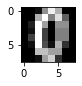

In [3]:
## Show one sample
sample_ind = 10
print("digit label:",digit_label[sample_ind] )
plt.figure(figsize = (1,1))
plt.imshow(data[sample_ind].reshape(8,8), cmap = "gray")

In [4]:
## Train test split

X_train, X_test, y_train, y_test = train_test_split(data, digit_label,
                                                    test_size=0.2, ## use 20% data for test
                                                    random_state=1, ## set random state for replication of experiment
                                                    stratify=digit_label ## stratify data instances based on their labels
                                                    )   
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (1437, 64)
Test data shape: (360, 64)


# Set up pipeline and gridsearch

In [5]:
## Initialize classifiers

clf1 = DecisionTreeClassifier(random_state=1)

clf2 = MLPClassifier(random_state=1)


## Initialize pipeline for Decision Tree and MLP repectively
pipe1 = Pipeline([('scaler', StandardScaler()),
                  ('clf1', clf1)])

pipe2 = Pipeline([('scaler', StandardScaler()),
                  ('clf2', clf2)])


## Setting up parameter grid

# Define the range of hyperparameter to search from
# The part can be change if you want to search other combinations of hyperparameters
param_grid_decisiontree = [{'clf1__max_depth': list(range(1, 10)) + [None]}]

param_grid_mlp = [{'clf2__alpha': [0.1, 0.01, 0.01, 0.001, 0.0001],
                   'clf2__hidden_layer_sizes': [(40,), (40,40)]}]



In [6]:
# Setting up multiple GridSearchCV objects

gridcvs = {} 
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1) # inner loop cross-validation with 3 folds

for pgrid, est, name in zip((param_grid_decisiontree, param_grid_mlp),
                            (pipe1, pipe2),
                            ('Decision Tree', 'MLP')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring = ['accuracy'], ## scoring metric can be also changed
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       refit="accuracy")
    gridcvs[name] = gcv
    
print(gridcvs)

{'Decision Tree': GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf1',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid=[{'clf1__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                              None]}],
             refit='accuracy', scoring=['accuracy']), 'MLP': GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf2',
                                        MLPClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid=[{'clf2__alpha': [0.1, 0.01, 0.01, 0.001, 0.0001],
                          'clf2__hidden_layer_sizes': [(40,), (40, 40)]}],
             refit='accuracy', scoring=['accuracy'])}


In [7]:
y_train.shape

(1437,)

In [8]:
## Define outer loop
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)


def nested_cross_val(features, labels, gridcvs):
    """ nested cross validation to compare across ML methods.
        features: the training dataset,
        labels: the corresponding labels for the training data """
    for method, gridsearch in sorted(gridcvs.items()):
        scores = cross_validate(gridsearch, 
                                       X=features, 
                                       y=labels, 
                                       cv=outer_cv,
                                       n_jobs=-1,
                                       return_estimator = True,
                                       scoring = ['accuracy', 'roc_auc_ovr'], ## roc_auc, f1 only works for binary class
                                       error_score="raise")

        auc = scores['test_roc_auc_ovr']
        accuracy = scores['test_accuracy']
        estimators = scores['estimator']

        print("Current method:",method)
        for i in estimators:
            print(i.best_params_) # show the best parameter with highest prediction accuracy
            print('\n')
        print('outer loop accuracy %.2f%% +/- %.2f' % 
              (accuracy.mean() * 100, accuracy.std() * 100))
        print('outer loop AUC %.2f%% +/- %.2f' % 
              (auc.mean() * 100, auc.std() * 100))
        ## Similarlly, you can also print out other scoring metrics
        print('\n')
    

nested_cross_val(X_train, y_train, gridcvs)

Current method: Decision Tree
{'clf1__max_depth': 9}


{'clf1__max_depth': None}


{'clf1__max_depth': 9}


outer loop accuracy 82.95% +/- 0.49
outer loop AUC 91.44% +/- 0.91


Current method: MLP
{'clf2__alpha': 0.1, 'clf2__hidden_layer_sizes': (40, 40)}


{'clf2__alpha': 0.1, 'clf2__hidden_layer_sizes': (40, 40)}


{'clf2__alpha': 0.01, 'clf2__hidden_layer_sizes': (40,)}


outer loop accuracy 97.15% +/- 1.39
outer loop AUC 99.87% +/- 0.07




In [9]:
## Fit the best model on the training set, and predict on the test set

def run_test(train_features, train_labels, test_features, test_labels, model_name, paramters):
    """Since MLP tends to be a better model for this dataset, we fit the model on the entire training set, and
    test on the test set."""
    model_select = GridSearchCV(estimator=model_name,
                                param_grid=paramters,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=inner_cv,
                                verbose=1,
                                refit=True)

    ## Fit the model on the entire training dataset
    model_select.fit(train_features, train_labels)
    
    best_model = model_select.best_estimator_
        
    train_acc = accuracy_score(y_true=train_labels, y_pred=best_model.predict(train_features))
    test_acc = accuracy_score(y_true=test_labels, y_pred=best_model.predict(test_features))

    print('Accuracy %.2f%% (average over k-fold CV test folds)' %
          (100 * model_select.best_score_))
    print('Best Parameters: %s' % model_select.best_params_)

    print('Training Accuracy: %.2f%%' % (100 * train_acc))
    print('Test Accuracy: %.2f%%' % (100 * test_acc))
    

## Standardize the test set
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

In [10]:
param_grid_mlp =  [{'alpha': [0.1, 0.01, 0.01, 0.001, 0.0001],
                    'hidden_layer_sizes': [(40,), (100,)]}]
run_test(X_train, y_train, X_test, y_test, clf2, param_grid_mlp)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Accuracy 97.22% (average over k-fold CV test folds)
Best Parameters: {'alpha': 0.1, 'hidden_layer_sizes': (100,)}
Training Accuracy: 100.00%
Test Accuracy: 81.67%
